In [ ]:
!pip install imbalanced-learn
!pip install seaborn
!pip install Sastrawi
!pip install openpyxl

In [2]:
import pandas as pd
import re
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from imblearn.over_sampling import RandomOverSampler

from collections import Counter, defaultdict

In [1]:
import pandas as pd

import pandas as pd

df = pd.read_excel("dataset_konsisten_full.xlsx")

positif = ['bagus', 'baik','hebat', 'mantap', 'mantep', 'puas', 'terbaik', 'luar biasa', 'percaya', 'menyenangkan', 'membantu', 'keren', 'peningkatan', 'upgrade', 'optimis',
           'signifikan', 'enak', 'meningkat', 'berhasil', 'semangat', 'seru', 'senang', 'cepat', 'efisien', 'bantu','beruntung', 'gokil', 'oke', 'tepat', 'rapi', 'berani',
           'mudah', 'jernih', 'adil', 'mengurangi', 'positif', 'tercepat', 'konsisten', 'makasih']

negatif = ['abolish', 'rugi', 'lama', 'kualitas_wasit', 'problem', 'buruk', 'kecewa', 'jelek', 'tidak puas', 'parah', 'gagal', 'salah', 'mengecewakan', 'burik', 'rendah',
           'kurang', 'jauh', 'miring', 'goyang', 'seadanya', 'hancur', 'percuma', 'burem', 'berantakan', 'mundur', 'kontra', 'kecil', 'delay', 'blur', 'susah', 'belum',
           'kesalahan', 'ngaco', 'dikit', 'jadul', 'mampus', 'ngelag', 'illegal', 'terbatas', 'sempit', 'bapuk', 'pelit', 'gelap', 'butek', 'apaan', 'zonk', 'dramatis',
           'mandek', 'berantem', 'kocak', 'kontroversi', 'kontroversial', 'merah', 'kabut', 'goblok', 'doang', 'pusing', 'gak bisa', 'blunder', 'miris', 'ngenes', 'bego',
           'kesel', 'kusem', 'kentang', 'malu', 'kabur', 'ilegal', 'lambat', 'asal', 'ngawur', 'error', 'ketinggalan', 'itu_mulu', 'aneh', 'waduh', 'cuma', 'ga akurat',
           'kurang canggih', 'gak sesuai', 'pecah', 'ampas', 'ga guna', 'pelanggaran']

netral = ["petition", "sign petition", "technology", "league", "football", "match official"]

def deteksi_sentimen(text):
    text = str(text).lower()
    if any(k in text for k in positif):
        return 'Positif'
    elif any(k in text for k in negatif):
        return 'Negatif'
    elif any(k in text for k in netral):
        return 'Netral'
    else:
        return 'Netral'  # fallback ke netral jika tidak terdeteksi

df['sentimen_baru'] = df['full_text'].apply(deteksi_sentimen)

# Drop kolom sentimen lama
df.drop(columns=['sentimen'], inplace=True)

# Simpan hasil
df.to_excel("data_terlabel_netral_n1.xlsx", index=False)

print("Label Netral sudah di labeli")

Label Netral sudah di labeli


In [3]:
# Tahap 1 CLEANING
# Fungsi pembersihan teks
df = pd.read_excel("data_terlabel_netral_n1.xlsx")
df_preprocessed = df.copy()

def clean_text(text):
    text = re.sub(r"http\S+|www.\S+", "", text)                        # URL
    text = re.sub(r'@\w+', '', text)                                   # Mention
    text = re.sub(r'#\w+', '', text)                                   # Hashtag
    text = re.sub(r'[^\w\s]', '', text)                                # Simbol
    text = re.sub(r'\d+', '', text)                                    # Angka
    text = re.sub(r'\s+', ' ', text).strip()                           # Spasi
    return text
    
df_preprocessed['cleaning'] = df_preprocessed['full_text'].apply(clean_text)
df_preprocessed[['full_text', 'cleaning']].head()



,full_text,cleaning
0,Ahhh burik banget VARnya Kualitasnya jauh dari...,Ahhh burik banget VARnya Kualitasnya jauh dari...
1,"Katanya mahal, tapi kok hasil VARnya biasa aja...",Katanya mahal tapi kok hasil VARnya biasa aja ya
2,Kamera VAR sering miring dan goyang jadi susah...,Kamera VAR sering miring dan goyang jadi susah...
3,"Gak nyaman banget gua liat kualitas VAR, tadi ...",Gak nyaman banget gua liat kualitas VAR tadi a...
4,@utdfocusid aku bandingin buat keseluruhan sep...,aku bandingin buat keseluruhan sepakbola indon...


In [4]:
# CASE FOLDING
# Membuat kalimat menjadi huruf kecil
df_preprocessed['case_folding'] = df_preprocessed['cleaning'].str.lower()
df_preprocessed[['full_text', 'cleaning', 'case_folding']].head()

,full_text,cleaning,case_folding
0,Ahhh burik banget VARnya Kualitasnya jauh dari...,Ahhh burik banget VARnya Kualitasnya jauh dari...,ahhh burik banget varnya kualitasnya jauh dari...
1,"Katanya mahal, tapi kok hasil VARnya biasa aja...",Katanya mahal tapi kok hasil VARnya biasa aja ya,katanya mahal tapi kok hasil varnya biasa aja ya
2,Kamera VAR sering miring dan goyang jadi susah...,Kamera VAR sering miring dan goyang jadi susah...,kamera var sering miring dan goyang jadi susah...
3,"Gak nyaman banget gua liat kualitas VAR, tadi ...",Gak nyaman banget gua liat kualitas VAR tadi a...,gak nyaman banget gua liat kualitas var tadi a...
4,@utdfocusid aku bandingin buat keseluruhan sep...,aku bandingin buat keseluruhan sepakbola indon...,aku bandingin buat keseluruhan sepakbola indon...


In [5]:
# TOKENIZING
# Fungsi tokenisasi sederhana menggunakan split
def tokenize(text):
    return text.split()

df_preprocessed['tokenizing'] = df_preprocessed['case_folding'].apply(tokenize)
df_preprocessed[['full_text', 'cleaning', 'case_folding', 'tokenizing']].head()

,full_text,cleaning,case_folding,tokenizing
0,Ahhh burik banget VARnya Kualitasnya jauh dari...,Ahhh burik banget VARnya Kualitasnya jauh dari...,ahhh burik banget varnya kualitasnya jauh dari...,"[ahhh, burik, banget, varnya, kualitasnya, jau..."
1,"Katanya mahal, tapi kok hasil VARnya biasa aja...",Katanya mahal tapi kok hasil VARnya biasa aja ya,katanya mahal tapi kok hasil varnya biasa aja ya,"[katanya, mahal, tapi, kok, hasil, varnya, bia..."
2,Kamera VAR sering miring dan goyang jadi susah...,Kamera VAR sering miring dan goyang jadi susah...,kamera var sering miring dan goyang jadi susah...,"[kamera, var, sering, miring, dan, goyang, jad..."
3,"Gak nyaman banget gua liat kualitas VAR, tadi ...",Gak nyaman banget gua liat kualitas VAR tadi a...,gak nyaman banget gua liat kualitas var tadi a...,"[gak, nyaman, banget, gua, liat, kualitas, var..."
4,@utdfocusid aku bandingin buat keseluruhan sep...,aku bandingin buat keseluruhan sepakbola indon...,aku bandingin buat keseluruhan sepakbola indon...,"[aku, bandingin, buat, keseluruhan, sepakbola,..."


In [6]:
# CONVERT NEGATION
def convert_negation(tokens, negation_words=['tidak', 'bukan', 'belum', 'jangan',
            'kurang', 'tak', 'ga', 'gak', 'enggak', 'ndak', 'nggak', 'tdk', 'ngga', 
            'ngak', 'gakk', 'bkn', 'jgn', 'kurng', 'krg', 'blum', 'jngn', 'jangn', 'tidak_bagus']):
    result = []
    skip = False
    for i in range(len(tokens) - 1):
        if skip:
            skip = False
            continue
        if tokens[i] in negation_words:
            result.append(tokens[i] + '_' + tokens[i + 1])
            skip = True
        else:
            result.append(tokens[i])
    if not skip:
        result.append(tokens[-1])
    return result

df_preprocessed['negation'] = df_preprocessed['tokenizing'].apply(convert_negation)
df_preprocessed[['full_text', 'cleaning', 'case_folding', 'tokenizing', 'negation']].head()

,full_text,cleaning,case_folding,tokenizing,negation
0,Ahhh burik banget VARnya Kualitasnya jauh dari...,Ahhh burik banget VARnya Kualitasnya jauh dari...,ahhh burik banget varnya kualitasnya jauh dari...,"[ahhh, burik, banget, varnya, kualitasnya, jau...","[ahhh, burik, banget, varnya, kualitasnya, jau..."
1,"Katanya mahal, tapi kok hasil VARnya biasa aja...",Katanya mahal tapi kok hasil VARnya biasa aja ya,katanya mahal tapi kok hasil varnya biasa aja ya,"[katanya, mahal, tapi, kok, hasil, varnya, bia...","[katanya, mahal, tapi, kok, hasil, varnya, bia..."
2,Kamera VAR sering miring dan goyang jadi susah...,Kamera VAR sering miring dan goyang jadi susah...,kamera var sering miring dan goyang jadi susah...,"[kamera, var, sering, miring, dan, goyang, jad...","[kamera, var, sering, miring, dan, goyang, jad..."
3,"Gak nyaman banget gua liat kualitas VAR, tadi ...",Gak nyaman banget gua liat kualitas VAR tadi a...,gak nyaman banget gua liat kualitas var tadi a...,"[gak, nyaman, banget, gua, liat, kualitas, var...","[gak_nyaman, banget, gua, liat, kualitas, var,..."
4,@utdfocusid aku bandingin buat keseluruhan sep...,aku bandingin buat keseluruhan sepakbola indon...,aku bandingin buat keseluruhan sepakbola indon...,"[aku, bandingin, buat, keseluruhan, sepakbola,...","[aku, bandingin, buat, keseluruhan, sepakbola,..."


In [7]:
# STEMMING
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_tokens(tokens):
    return [stemmer.stem(word) for word in tokens]

df_preprocessed['stemming'] = df_preprocessed['negation'].apply(stem_tokens)
df_preprocessed[['full_text', 'cleaning', 'case_folding', 'tokenizing', 'negation', 'stemming']].head()

,full_text,cleaning,case_folding,tokenizing,negation,stemming
0,Ahhh burik banget VARnya Kualitasnya jauh dari...,Ahhh burik banget VARnya Kualitasnya jauh dari...,ahhh burik banget varnya kualitasnya jauh dari...,"[ahhh, burik, banget, varnya, kualitasnya, jau...","[ahhh, burik, banget, varnya, kualitasnya, jau...","[ahhh, burik, banget, varnya, kualitas, jauh, ..."
1,"Katanya mahal, tapi kok hasil VARnya biasa aja...",Katanya mahal tapi kok hasil VARnya biasa aja ya,katanya mahal tapi kok hasil varnya biasa aja ya,"[katanya, mahal, tapi, kok, hasil, varnya, bia...","[katanya, mahal, tapi, kok, hasil, varnya, bia...","[kata, mahal, tapi, kok, hasil, varnya, biasa,..."
2,Kamera VAR sering miring dan goyang jadi susah...,Kamera VAR sering miring dan goyang jadi susah...,kamera var sering miring dan goyang jadi susah...,"[kamera, var, sering, miring, dan, goyang, jad...","[kamera, var, sering, miring, dan, goyang, jad...","[kamera, var, sering, miring, dan, goyang, jad..."
3,"Gak nyaman banget gua liat kualitas VAR, tadi ...",Gak nyaman banget gua liat kualitas VAR tadi a...,gak nyaman banget gua liat kualitas var tadi a...,"[gak, nyaman, banget, gua, liat, kualitas, var...","[gak_nyaman, banget, gua, liat, kualitas, var,...","[gak nyaman, banget, gua, liat, kualitas, var,..."
4,@utdfocusid aku bandingin buat keseluruhan sep...,aku bandingin buat keseluruhan sepakbola indon...,aku bandingin buat keseluruhan sepakbola indon...,"[aku, bandingin, buat, keseluruhan, sepakbola,...","[aku, bandingin, buat, keseluruhan, sepakbola,...","[aku, bandingin, buat, seluruh, sepakbola, ind..."


In [8]:
# STOPWORD REMOVAL
stopwords_df = pd.read_excel("kamus_stopwords.xlsx")
stopwords = set(stopwords_df['stopword'].dropna().astype(str).str.lower())

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stopwords]

df_preprocessed['stopword_removal'] = df_preprocessed['stemming'].apply(remove_stopwords)
df_preprocessed[['full_text', 'cleaning', 'case_folding', 'tokenizing', 'negation', 'stemming', 'stopword_removal']].head()

,full_text,cleaning,case_folding,tokenizing,negation,stemming,stopword_removal
0,Ahhh burik banget VARnya Kualitasnya jauh dari...,Ahhh burik banget VARnya Kualitasnya jauh dari...,ahhh burik banget varnya kualitasnya jauh dari...,"[ahhh, burik, banget, varnya, kualitasnya, jau...","[ahhh, burik, banget, varnya, kualitasnya, jau...","[ahhh, burik, banget, varnya, kualitas, jauh, ...","[ahhh, burik, varnya, kualitas, harap]"
1,"Katanya mahal, tapi kok hasil VARnya biasa aja...",Katanya mahal tapi kok hasil VARnya biasa aja ya,katanya mahal tapi kok hasil varnya biasa aja ya,"[katanya, mahal, tapi, kok, hasil, varnya, bia...","[katanya, mahal, tapi, kok, hasil, varnya, bia...","[kata, mahal, tapi, kok, hasil, varnya, biasa,...","[mahal, hasil, varnya]"
2,Kamera VAR sering miring dan goyang jadi susah...,Kamera VAR sering miring dan goyang jadi susah...,kamera var sering miring dan goyang jadi susah...,"[kamera, var, sering, miring, dan, goyang, jad...","[kamera, var, sering, miring, dan, goyang, jad...","[kamera, var, sering, miring, dan, goyang, jad...","[kamera, var, miring, goyang, susah, ngliat, l..."
3,"Gak nyaman banget gua liat kualitas VAR, tadi ...",Gak nyaman banget gua liat kualitas VAR tadi a...,gak nyaman banget gua liat kualitas var tadi a...,"[gak, nyaman, banget, gua, liat, kualitas, var...","[gak_nyaman, banget, gua, liat, kualitas, var,...","[gak nyaman, banget, gua, liat, kualitas, var,...","[gak nyaman, liat, kualitas, var, main, offsid..."
4,@utdfocusid aku bandingin buat keseluruhan sep...,aku bandingin buat keseluruhan sepakbola indon...,aku bandingin buat keseluruhan sepakbola indon...,"[aku, bandingin, buat, keseluruhan, sepakbola,...","[aku, bandingin, buat, keseluruhan, sepakbola,...","[aku, bandingin, buat, seluruh, sepakbola, ind...","[bandingin, sepakbola, era, liga, putri, gaada..."


In [9]:
# Ubah list kata hasil stopword removal menjadi kalimat
df_preprocessed['text_stemmed'] = df_preprocessed['stopword_removal'].apply(lambda tokens: ' '.join(tokens))
df_preprocessed[['full_text', 'cleaning', 'case_folding', 'tokenizing', 'negation', 'stemming', 'stopword_removal', 'text_stemmed']].head()

,full_text,cleaning,case_folding,tokenizing,negation,stemming,stopword_removal,text_stemmed
0,Ahhh burik banget VARnya Kualitasnya jauh dari...,Ahhh burik banget VARnya Kualitasnya jauh dari...,ahhh burik banget varnya kualitasnya jauh dari...,"[ahhh, burik, banget, varnya, kualitasnya, jau...","[ahhh, burik, banget, varnya, kualitasnya, jau...","[ahhh, burik, banget, varnya, kualitas, jauh, ...","[ahhh, burik, varnya, kualitas, harap]",ahhh burik varnya kualitas harap
1,"Katanya mahal, tapi kok hasil VARnya biasa aja...",Katanya mahal tapi kok hasil VARnya biasa aja ya,katanya mahal tapi kok hasil varnya biasa aja ya,"[katanya, mahal, tapi, kok, hasil, varnya, bia...","[katanya, mahal, tapi, kok, hasil, varnya, bia...","[kata, mahal, tapi, kok, hasil, varnya, biasa,...","[mahal, hasil, varnya]",mahal hasil varnya
2,Kamera VAR sering miring dan goyang jadi susah...,Kamera VAR sering miring dan goyang jadi susah...,kamera var sering miring dan goyang jadi susah...,"[kamera, var, sering, miring, dan, goyang, jad...","[kamera, var, sering, miring, dan, goyang, jad...","[kamera, var, sering, miring, dan, goyang, jad...","[kamera, var, miring, goyang, susah, ngliat, l...",kamera var miring goyang susah ngliat langgar
3,"Gak nyaman banget gua liat kualitas VAR, tadi ...",Gak nyaman banget gua liat kualitas VAR tadi a...,gak nyaman banget gua liat kualitas var tadi a...,"[gak, nyaman, banget, gua, liat, kualitas, var...","[gak_nyaman, banget, gua, liat, kualitas, var,...","[gak nyaman, banget, gua, liat, kualitas, var,...","[gak nyaman, liat, kualitas, var, main, offsid...",gak nyaman liat kualitas var main offside cek ...
4,@utdfocusid aku bandingin buat keseluruhan sep...,aku bandingin buat keseluruhan sepakbola indon...,aku bandingin buat keseluruhan sepakbola indon...,"[aku, bandingin, buat, keseluruhan, sepakbola,...","[aku, bandingin, buat, keseluruhan, sepakbola,...","[aku, bandingin, buat, seluruh, sepakbola, ind...","[bandingin, sepakbola, era, liga, putri, gaada...",bandingin sepakbola era liga putri gaada liga ...


In [10]:
# Simpan hasil preprocessing
df_preprocessed.to_excel("hasil_preprocessing_n1.xlsx", index=False)

In [12]:
# Bagi Data Latih dan Data Uji
# Baca file hasil preprocessing
df = pd.read_excel("hasil_preprocessing_n1.xlsx")

# Hapus baris kosong pada kolom yang dibutuhkan
df = df.dropna(subset=['text_stemmed', 'sentimen_baru','aspek'])
# Pisahkan fitur dan label
X = df[['text_stemmed', 'aspek', 'sentimen_baru']]
# Split data (90% latih, 10% uji)
train_df, test_df = train_test_split(X, test_size=0.2, random_state=42, stratify=df['sentimen_baru'])
# Simpan ke Excel
train_df.to_excel("data_latih_n1.xlsx", index=False)
test_df.to_excel("data_uji_n1.xlsx", index=False)

print("Jumlah data latih:", len(train_df))
print("Jumlah data uji  :", len(test_df))

Jumlah data latih: 3305
Jumlah data uji  : 827


In [13]:
from collections import Counter

train_vocab = Counter(" ".join(train_df['text_stemmed']).split())
test_vocab = Counter(" ".join(test_df['text_stemmed']).split())

common_words = set(train_vocab).intersection(set(test_vocab))
coverage = len(common_words) / len(test_vocab)

print(f"Coverage vocab test yang ada di train: {coverage*100:.2f}%")


Coverage vocab test yang ada di train: 79.34%


In [14]:
import numpy as np

# Cek proporsi vektor nol (artinya OOV semua)
zero_vector_count = np.sum(test_df.sum(axis=1) == 0)
print(f"Data uji yang semua katanya OOV: {zero_vector_count} dari {test_df.shape[0]}")


Data uji yang semua katanya OOV: 0 dari 827


In [18]:
# Oversampling untuk menyeimbangkan data
# Baca data latih yang sudah dibagi
df_train = pd.read_excel("data_latih_n1.xlsx")
# Tambahkan label gabungan aspek_sentimen
df_train['aspek_sentimen'] = df_train['aspek'].str.lower().str.strip() + "_" + df_train['sentimen_baru'].astype(str)

# Lihat distribusi sebelum oversampling
print("Distribusi Sebelum Oversampling:")
print(df_train['aspek_sentimen'].value_counts())

# Siapkan fitur dan label gabungan untuk oversampling
X = df_train[['text_stemmed']]
y = df_train['aspek_sentimen']

# Menerapkan Random Over-Sampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Gabungkan hasil menjadi DataFrame baru
df_oversampled = X_resampled.copy()
df_oversampled['aspek_sentimen'] = y_resampled
# Pisahkan kembali kolom 'aspek' dan 'sentimen'
df_oversampled['aspek'] = df_oversampled['aspek_sentimen'].apply(lambda x: x.split('_')[0])
df_oversampled['sentimen'] = df_oversampled['aspek_sentimen'].apply(lambda x: x.split('_')[1].capitalize())

df_oversampled[['text_stemmed', 'aspek', 'sentimen']].to_excel("data_latih_oversampled_n1.xlsx", index=False)

# Tampilkan distribusi setelah oversampling
print("\nDistribusi Setelah Oversampling:")
print(df_oversampled['aspek_sentimen'].value_counts())

print("\nJumlah data sebelum oversampling:", len(df_train))
print("Jumlah data setelah oversampling :", len(df_oversampled))

Distribusi Sebelum Oversampling:
aspek_sentimen
kualitas_Negatif    726
kualitas_Positif    683
kamera_Negatif      507
kualitas_Netral     421
kamera_Positif      343
kamera_Netral       316
harga_Positif       111
harga_Negatif       108
harga_Netral         90
Name: count, dtype: int64

Distribusi Setelah Oversampling:
aspek_sentimen
kualitas_Positif    726
harga_Positif       726
kualitas_Negatif    726
kualitas_Netral     726
kamera_Netral       726
kamera_Negatif      726
kamera_Positif      726
harga_Negatif       726
harga_Netral        726
Name: count, dtype: int64

Jumlah data sebelum oversampling: 3305
Jumlah data setelah oversampling : 6534


In [7]:
# Menghitung TF, DF, dan IDF dari teks yang sudah diproses
# Baca hasil data latih oversampling
df_train = pd.read_excel("data_latih_oversampled.xlsx")

# Menggunakan kolom text_stemmed sebagai teks
corpus = df_train['text_stemmed']
# Hitung Term Frequency (TF)
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=1000)
tf_matrix = vectorizer.fit_transform(corpus)
# Ubah TF menjadi DataFrame dengan term sebagai baris, dokumen sebagai kolom
tf_df = pd.DataFrame(tf_matrix.toarray(), columns=vectorizer.get_feature_names_out()).T
# Tambahkan kolom 'No.' dan 'Term'
tf_df.insert(0, 'Term', tf_df.index)
tf_df.insert(0, 'No.', range(1, len(tf_df) + 1))
# Hitung Document Frequency (DF)
df_counts = (tf_matrix > 0).sum(axis=0).A1
df_series = pd.Series(df_counts, index=vectorizer.get_feature_names_out())
# Hitung IDF dengan rumus log(N / DF) + 1
N = tf_matrix.shape[0]
idf_values = [round(math.log((N / (df_val if df_val != 0 else 1)) + 1), 3) for df_val in df_series]
# Tambahkan kolom DF dan IDF
tf_df['DF'] = df_series.values
tf_df['IDF'] = idf_values
# Ubah nama kolom dokumen: D1, D2, ..., Dn
doc_cols = [f'D{i+1}' for i in range(tf_matrix.shape[0])]
tf_df.columns = ['No.', 'Term'] + doc_cols + ['DF', 'IDF']

tf_df.head()

,No.,Term,D1,D2,D3,D4,D5,D6,D7,D8,...,D4844,D4845,D4846,D4847,D4848,D4849,D4850,D4851,DF,IDF
ada,1,ada,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.268567,0.0,0.0,0.0,0.0,0.0,0.0,170,3.386
ada cek,2,ada cek,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,16,5.718
ada cek var,3,ada cek var,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,16,5.718
ada var,4,ada var,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,20,5.495
adil,5,adil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,111,3.800


In [8]:
tf_df.to_excel("hasilperhitungan_TFDFIDF.xlsx", index=False)

In [ ]:
# Menghitung bobot TF-IDF
# Baca hasil TF DF dan IDF
df_tf_idf = pd.read_excel("hasilperhitungan_TFDFIDF.xlsx")

# Pisahkan kolom yang berisi TF
doc_cols = [col for col in df_tf_idf.columns if col.startswith('D')]
# Hitung TF × IDF: untuk setiap TF dikali IDF per term (baris)
tf_only = df_tf_idf[doc_cols]
idf_column = df_tf_idf['IDF']
# Kalikan TF dengan IDF
tfidf_weight = tf_only.multiply(idf_column, axis=0)
# Gabungkan kembali dengan kolom Term dan No
tfidf_weight.insert(0, 'Term', df_tf_idf['Term'])
tfidf_weight.insert(0, 'No.', df_tf_idf['No.'])

tfidf_weight.head()

In [10]:
tfidf_weight.to_excel("hasilbobot_TF_IDF.xlsx", index=False)

In [11]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest

# Seleksi Fitur Chi Square
# Baca bobot TF-IDF
df_tfidf = pd.read_excel("hasilbobot_TF_IDF.xlsx")
# Ambil hanya kolom dokumen D1, D2, ..., Dn
doc_cols = [col for col in df_tfidf.columns if col.startswith("D")]
X_tfidf = df_tfidf[doc_cols].T
# Baca label dari file data latih
df_label = pd.read_excel("data_latih_oversampled.xlsx")
df_label = df_label.dropna(subset=['aspek', 'sentimen'])
# Pastikan jumlah dokumen dan label sesuai
X_tfidf = X_tfidf.iloc[:len(df_label), :]
# Gabungkan label aspek dan sentimen sebagai kelas
y_label = df_label['aspek'].astype(str).str.lower().str.strip() + "_" + df_label['sentimen'].astype(str).str.lower().str.strip()

# Encode label menjadi numerik
le = LabelEncoder()
y_encoded = le.fit_transform(y_label)

# Seleksi fitur Chi-Square
selector = SelectKBest(score_func=mutual_info_classif, k=500)
X_selected = selector.fit_transform(X_tfidf, y_encoded)

# Ambil nama-nama term fitur terpilih
selected_indices = selector.get_support(indices=True)
selected_terms = df_tfidf.loc[selected_indices, 'Term'].values

# Simpan ke file
df_selected = pd.DataFrame(X_selected, columns=selected_terms)
df_selected.insert(0, 'Label', y_label.values)
df_selected.to_excel("fitur_terpilih_chisquare.xlsx", index=False)

# Tampilkan informasi
print("Jumlah fitur terpilih:", len(selected_terms))
print("Contoh fitur terpilih:")
print(selected_terms[:20])
selected_indices = selector.get_support(indices=True)


Jumlah fitur terpilih: 500
Contoh fitur terpilih:
['ada' 'ada cek' 'ada cek var' 'adil' 'adil kualitas' 'aktif langgan'
 'alat' 'alat mahal' 'alat var' 'alat var mahal' 'ambil' 'ambil putus'
 'amburadul' 'anak' 'aneh' 'anggar' 'anggar gede' 'anggar nambah'
 'anggar var' 'angle']


In [12]:
#cosine

# Menghitung Jarak Cosine
# Baca data fitur hasil seleksi
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

df_selected = pd.read_excel("fitur_terpilih_chisquare.xlsx")

# Pisahkan label dari fitur
X_features = df_selected.drop(columns=['Label'])

# Hitung cosine similarity
similarity_matrix = cosine_similarity(X_features)

# Ubah menjadi jarak: 1 - similarity
distance_matrix = 1 - similarity_matrix

# Simpan hasil ke DataFrame
distance_df = pd.DataFrame(
    distance_matrix,
    index=[f'D{i+1}' for i in range(len(X_features))],
    columns=[f'D{i+1}' for i in range(len(X_features))]
)

# Simpan ke file
distance_df.to_excel("hasiljarak_cosine.xlsx")
print(distance_df.head())



              D1        D2            D3            D4        D5        D6  \
D1  1.110223e-16  0.991039  9.990891e-01  8.856758e-01  0.921372  0.977877   
D2  9.910394e-01  0.000000  9.788064e-01  1.000000e+00  0.993140  0.995014   
D3  9.990891e-01  0.978806 -2.220446e-16  1.000000e+00  0.999303  1.000000   
D4  8.856758e-01  1.000000  1.000000e+00  2.220446e-16  1.000000  0.990286   
D5  9.213721e-01  0.993140  9.993026e-01  1.000000e+00  0.000000  0.996283   

          D7        D8        D9       D10  ...     D4842     D4843     D4844  \
D1  0.998680  0.983636  0.998943  0.999440  ...  0.998794  0.950387  0.999403   
D2  0.969285  0.999451  0.998915  0.999425  ...  0.998762  0.995671  0.999387   
D3  0.970873  0.999480  0.998971  0.999455  ...  0.998826  0.999560  0.999419   
D4  0.622371  0.991096  1.000000  0.927625  ...  1.000000  1.000000  1.000000   
D5  0.998989  0.999591  0.999191  0.999571  ...  0.999077  0.962017  0.999543   

       D4845     D4846     D4847     D4848  

In [13]:
# Validitas Aspek - dari hasil jarak cosine
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Baca matriks jarak cosine
df_jarak = pd.read_excel("hasiljarak_cosine.xlsx", index_col=0)

# Baca label aspek
df_label = pd.read_excel("data_latih_oversampled.xlsx")
df_label = df_label.dropna(subset=['aspek'])
aspek = df_label['aspek'].str.lower().str.strip()

# Encode label
le = LabelEncoder()
labels = le.fit_transform(aspek)
labels = labels[:len(df_jarak)]

k = 3
validitas_aspek = []

for i in range(len(labels)):
    dok_i = f'D{i+1}'
    distances = df_jarak.loc[dok_i].copy()
    distances.iloc[i] = np.inf
    nearest_indices = distances.nsmallest(k).index
    tetangga_idx = [int(d[1:]) - 1 for d in nearest_indices]
    skor_s = [1 if labels[i] == labels[j] else 0 for j in tetangga_idx]
    validitas = sum(skor_s) / k
    validitas_aspek.append(validitas)

df_validitas = pd.DataFrame({
    'Data': [f'D{i+1}' for i in range(len(validitas_aspek))],
    'Validitas_Aspek': validitas_aspek
})
df_validitas.to_excel("validitas_aspek.xlsx", index=False)
print(df_validitas.head())


  Data  Validitas_Aspek
0   D1         1.000000
1   D2         0.666667
2   D3         1.000000
3   D4         0.000000
4   D5         1.000000


In [16]:
# Validitas Aspek - dari hasil jarak cosine
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Baca matriks jarak cosine
df_jarak = pd.read_excel("hasiljarak_cosine.xlsx", index_col=0)

# Baca label aspek
df_label = pd.read_excel("data_latih_oversampled.xlsx")
df_label = df_label.dropna(subset=['sentimen'])
sentimen = df_label['sentimen'].str.lower().str.strip()

# Encode label
le = LabelEncoder()
labels = le.fit_transform(sentimen)
labels = labels[:len(df_jarak)]

k = 3
validitas_sentimen = []

for i in range(len(labels)):
    dok_i = f'D{i+1}'
    distances = df_jarak.loc[dok_i].copy()
    distances.iloc[i] = np.inf
    nearest_indices = distances.nsmallest(k).index
    tetangga_idx = [int(d[1:]) - 1 for d in nearest_indices]
    skor_s = [1 if labels[i] == labels[j] else 0 for j in tetangga_idx]
    validitas = sum(skor_s) / k
    validitas_sentimen.append(validitas)

df_validitas = pd.DataFrame({
    'Data': [f'D{i+1}' for i in range(len(validitas_sentimen))],
    'Validitas_sentimen': validitas_sentimen
})
df_validitas.to_excel("validitas_sentimen.xlsx", index=False)
print(df_validitas.head())


  Data  Validitas_sentimen
0   D1            0.333333
1   D2            0.333333
2   D3            0.333333
3   D4            1.000000
4   D5            1.000000


In [ ]:
# Menghitung TF, DF, dan IDF data latih dan data uji
# Baca data latih dan data uji
df_latih = pd.read_excel("data_latih_oversampled.xlsx")
df_uji = pd.read_excel("data_uji.xlsx")

# Gabungkan kolom teks dari latih dan uji
dokumen_latih = df_latih['text_stemmed'].dropna().tolist()
dokumen_uji = df_uji['text_stemmed'].dropna().tolist()
dokumen_all = dokumen_latih + dokumen_uji

# Buat label dokumen seperti D1, D2, ..., Dn
doc_names = [f'D{i+1}' for i in range(len(dokumen_all))]

# Hitung TF menggunakan CountVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tf_matrix = vectorizer.fit_transform(dokumen_all)

# Konversi ke DataFrame
tf_df = pd.DataFrame(tf_matrix.toarray().T, 
                     index=vectorizer.get_feature_names_out(), 
                     columns=doc_names)

# Hitung DF (berapa banyak dokumen yang mengandung term)
df_series = (tf_df > 0).sum(axis=1)

# Hitung IDF dengan rumus log10(N / (1 + DF))
N = len(dokumen_all)
idf_series = df_series.apply(lambda df: round(math.log10(N / (1 + df)), 3))

# Gabungkan semua ke satu DataFrame
hasil_df = tf_df.copy()
hasil_df['DF'] = df_series
hasil_df['IDF'] = idf_series
hasil_df.insert(0, 'No.', range(1, len(hasil_df) + 1))
hasil_df.insert(1, 'Term', hasil_df.index)

# Simpan ke Excel
hasil_df.reset_index(drop=True, inplace=True)
hasil_df.to_excel("hasilperhitungan_TFDFIDF_Latih_Uji.xlsx", index=False)

print("Hasil TF, DF, IDF untuk data latih dan uji berhasil disimpan ke 'hasilperhitungan_TFDFIDF_Latih_Uji.xlsx'")

In [ ]:
# Menghitung bobot TF-IDF data latih dan uji
# Baca hasil TF, DF, IDF dari file sebelumnya
df_tf_idf = pd.read_excel("hasilperhitungan_TFDFIDF_Latih_Uji.xlsx")

# Ambil kolom-kolom dokumen (D1, D2, ..., Dn)
doc_cols = [col for col in df_tf_idf.columns if col.startswith('D')]
# Kalikan setiap nilai TF dengan IDF untuk setiap term
tf_only = df_tf_idf[doc_cols]
idf_values = df_tf_idf['IDF']
tfidf_matrix = tf_only.multiply(idf_values, axis=0)

# Tambahkan kolom No. dan Term
tfidf_matrix.insert(0, 'Term', df_tf_idf['Term'])
tfidf_matrix.insert(0, 'No.', df_tf_idf['No.'])

# Simpan hasil ke Excel
tfidf_matrix.to_excel("hasilbobot_TFIDF_Latih_Uji.xlsx", index=False)
# Tampilkan hasil 10 baris pertama
print("Hasil TF × IDF untuk data latih dan uji:")
display(tfidf_matrix.head(10))

In [ ]:
# Menghitung jarak cosine data uji ke latih
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Baca hasil TF-IDF gabungan latih + uji
df_tfidf = pd.read_excel("hasilbobot_TFIDF_Latih_Uji.xlsx")

# Tentukan jumlah data latih dan uji
n_latih = pd.read_excel("data_latih_oversampled.xlsx").shape[0]
n_uji = pd.read_excel("data_uji.xlsx").shape[0]

# Ambil kolom D1 ... Dn
doc_cols = [col for col in df_tfidf.columns if col.startswith('D')]
tfidf_matrix = df_tfidf[doc_cols].T

# Pisahkan data latih dan data uji
tfidf_latih = tfidf_matrix.iloc[:n_latih, :]
tfidf_uji = tfidf_matrix.iloc[n_latih:, :]

# Hitung jarak cosine dari setiap data uji ke semua data latih
jarak_list = []
for idx, uji_vec in tfidf_uji.reset_index(drop=True).iterrows():
    similarities = cosine_similarity([uji_vec], tfidf_latih)[0]
    distances = 1 - similarities
    jarak_df = pd.DataFrame({
        'Data Latih ke-': [f'D{j+1}' for j in range(n_latih)],
        'Besar Jarak': distances
    })
    jarak_list.append((f'Uji ke-{idx + 1}', jarak_df))

# Simpan hasil ke file Excel multitab
with pd.ExcelWriter("hasil_jarak_cosine_uji_vs_latih.xlsx") as writer:
    for nama_uji, df_jarak in jarak_list:
        df_jarak.to_excel(writer, sheet_name=nama_uji[:31], index=False)

print(jarak_list[0][1].head())


In [ ]:
alpha = 1e-6

# Baca validitas aspek hasil cosine distance
df_validitas = pd.read_excel("validitas_aspek.xlsx")
validitas_dict = dict(zip(df_validitas['Data'], df_validitas['Validitas_Aspek']))

# Baca hasil jarak dari satu data uji (misalnya Uji ke-1)
df_jarak = pd.read_excel("hasil_jarak_cosine_uji_vs_latih.xlsx", sheet_name="Uji ke-1")

weight_list = []
for i, row in df_jarak.iterrows():
    dok = row['Data Latih ke-']
    jarak = row['Besar Jarak ']  # sesuaikan nama kolom
    valid = validitas_dict.get(dok, 0)
    weight = round(valid / (jarak + alpha), 3)
    weight_list.append((dok, weight))

df_weight = pd.DataFrame(weight_list, columns=['Data Ke-', 'Nilai Weight Voting Aspek'])

print("Hasil perhitungan weight voting aspek:")
print(df_weight.head())


In [ ]:
df_weight.to_excel("hasil_weightvoting_aspek_uji1.xlsx", index=False)

In [ ]:

#lama
# Melakukan prediksi aspek dari satu data uji
# Parameter MKNN
k = 50
alpha = 1e-6

# Load data
df_validitas = pd.read_excel("validitas_aspek.xlsx")
df_latih = pd.read_excel("data_latih_oversampled.xlsx")
df_jarak = pd.read_excel("hasil_jarak_cosine_uji_vs_latih.xlsx", sheet_name="Uji ke-1")

# Buat dictionary validitas dan label aspek
validitas_dict = dict(zip(df_validitas['Data'], df_validitas['Validitas_Aspek']))
label_dict = dict(zip([f'D{i+1}' for i in range(len(df_latih))], df_latih['aspek']))

# Hitung weight voting: validitas / (jarak + alpha)
weight_data = []
for i, row in df_jarak.iterrows():
    dok = row['Data Latih ke-']
    jarak = row['Besar Jarak']
    valid = validitas_dict.get(dok, 0)
    label = label_dict.get(dok, 'Unknown')
    weight = round(valid / (jarak + alpha), 3)
    weight_data.append((dok, weight, label))

# Ambil k tetangga terdekat berbobot tertinggi
sorted_weights = sorted(weight_data, key=lambda x: x[1], reverse=True)[:k]
# Buat DataFrame dari k tetangga
df_k = pd.DataFrame(sorted_weights, columns=['Data Latih Ke-', 'Weight Voting', 'Aspek'])
# Prediksi berdasarkan mayoritas label
prediksi_aspek = df_k['Aspek'].mode()[0]
# Tambahkan prediksi ke tabel
df_k.loc[k] = ["Prediksi", "", prediksi_aspek]
# Tampilkan hasil
print("Hasil prediksi aspek untuk Uji ke-1:")
print(df_k)

In [ ]:
df_k.to_excel("hasilklasifikasi_aspek_uji1.xlsx", index=False)

In [ ]:
# Menghitung nilai weight voting aspek dalam algoritma MKNN
# Nilai smoothing alpha (untuk menghindari pembagian dengan nol)
alpha = 0.5
# Baca validitas aspek
df_validitas = pd.read_excel("validitas_sentimen.xlsx")
validitas_dict = dict(zip(df_validitas['Data Ke-'], df_validitas['Validitas Sentimen']))
# Baca hasil jarak dari satu data uji (misalnya Uji ke-1)
df_jarak = pd.read_excel("hasil_jarak_cosine_uji_vs_latih.xlsx", sheet_name="Uji ke-1")
# Hitung weight voting berdasarkan rumus W(i) = Validity(i) × 1 / (d_i + α)
weight_list = []
for i, row in df_jarak.iterrows():
    dok = row['Data Latih ke-']
    jarak = row['Besar Jarak Cosine']
    valid = validitas_dict.get(dok, 0)
    weight = round(valid / (jarak + alpha), 3)  
    weight_list.append((dok, weight))

# Buat DataFrame hasil
df_weight = pd.DataFrame(weight_list, columns=['Data Ke-', 'Nilai Weight Voting Sentimen'])

# Tampilkan 5 baris pertama
print("Hasil perhitungan weight voting sentimen:")
print(df_weight.head())

In [ ]:
df_k.to_excel("hasilklasifikasi_sentimen_uji1.xlsx", index=False)

In [ ]:
#lama
# Melakukan prediksi sentimen dari satu data uji
# Parameter MKNN
k = 30
alpha = 1e-6  # smoothing
# Baca data yang dibutuhkan
df_jarak = pd.read_excel("hasil_jarak_cosine_uji_vs_latih.xlsx", sheet_name="Uji ke-1")
df_valid_sentimen = pd.read_excel("hasilvaliditas_sentimen.xlsx")
df_train = pd.read_excel("data_latih_oversampled.xlsx")
# Buat dictionary: validitas dan label sentimen
validitas_dict = dict(zip(df_valid_sentimen['Data Ke-'], df_valid_sentimen['Nilai Validitas Sentimen']))
label_dict = dict(zip([f'D{i+1}' for i in range(len(df_train))], df_train['sentimen']))
# Hitung weight voting: validitas / (jarak + alpha)
weight_data = []
for i, row in df_jarak.iterrows():
    dok = row['Data Latih ke-']
    jarak = row['Besar Jarak Cosine']
    valid = validitas_dict.get(dok, 0)
    label = label_dict.get(dok, 'Unknown')
    weight = round(valid / (jarak + alpha), 3)
    weight_data.append((dok, weight, label))
# Ambil k tetangga dengan weight tertinggi
sorted_weights = sorted(weight_data, key=lambda x: x[1], reverse=True)[:k]
# Buat DataFrame hasil voting
df_k = pd.DataFrame(sorted_weights, columns=[
    'Data Latih Ke-', 'Weight Voting', 'Label Sentimen'
])
# Prediksi sentimen berdasarkan mayoritas
prediksi_sentimen = df_k['Label Sentimen'].mode()[0]
# Tambahkan prediksi ke tabel
df_k.loc[k] = ["Prediksi", "", prediksi_sentimen]
# Tampilkan hasil
print("Hasil prediksi sentimen untuk Uji ke-1:")
print(df_k)

In [ ]:
print(df['sentimen'].value_counts())

In [ ]:
df_k.to_excel("hasilklasifikasi_sentimen_uji1.xlsx", index=False)


=== Evaluasi MKNN Aspek dengan k=20 ===

Confusion Matrix Fold-1 (k=20) | F1-macro: 78.81


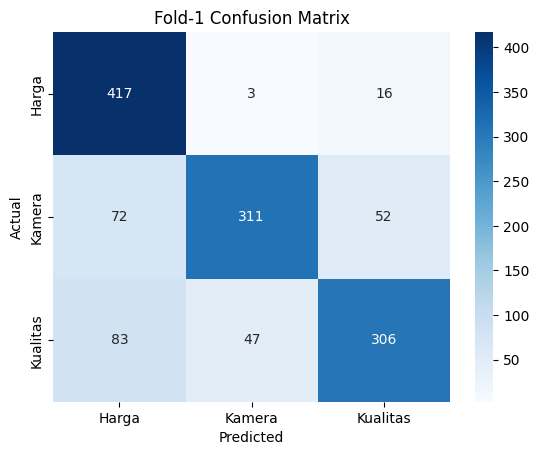


Confusion Matrix Fold-2 (k=20) | F1-macro: 73.48


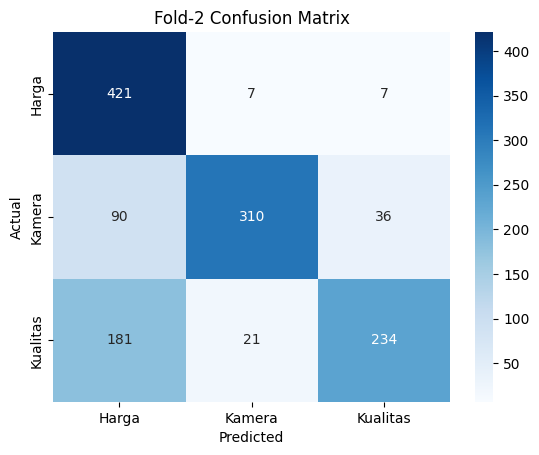


Confusion Matrix Fold-3 (k=20) | F1-macro: 75.18


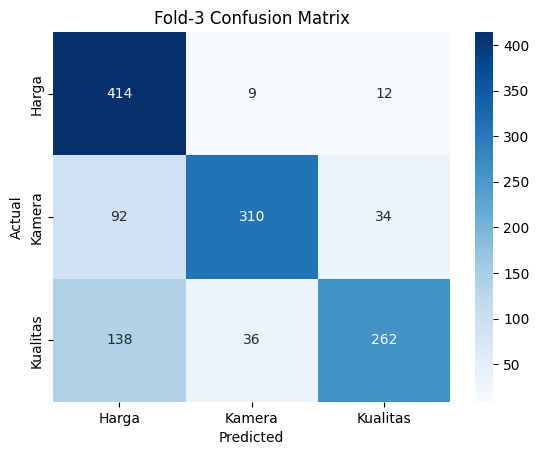


Confusion Matrix Fold-4 (k=20) | F1-macro: 76.91


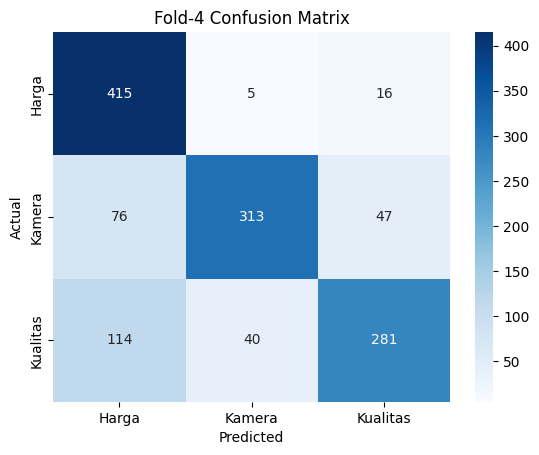


Confusion Matrix Fold-5 (k=20) | F1-macro: 78.91


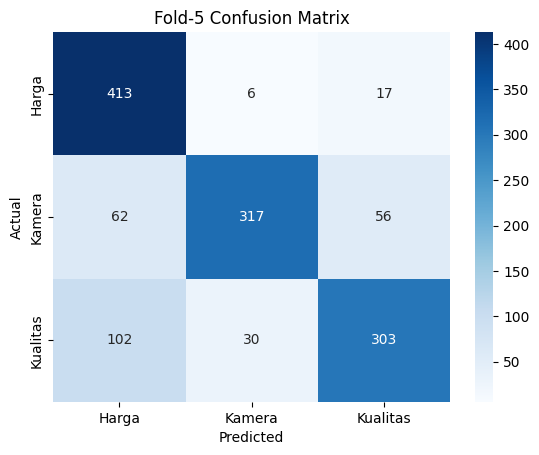


=== Evaluasi MKNN Aspek dengan k=26 ===

Confusion Matrix Fold-1 (k=26) | F1-macro: 80.28


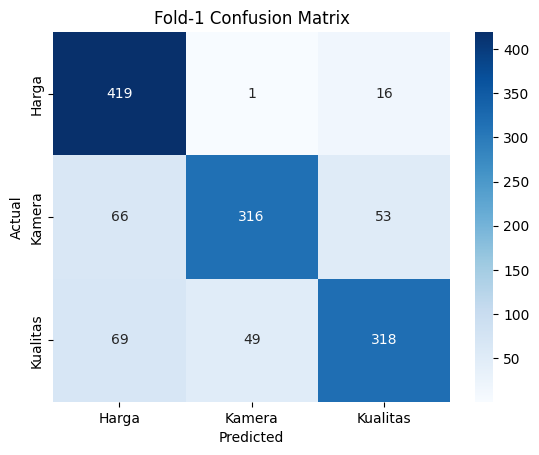


Confusion Matrix Fold-2 (k=26) | F1-macro: 76.50


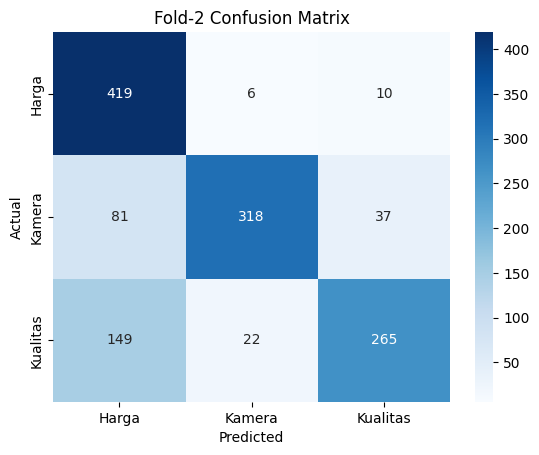


Confusion Matrix Fold-3 (k=26) | F1-macro: 75.83


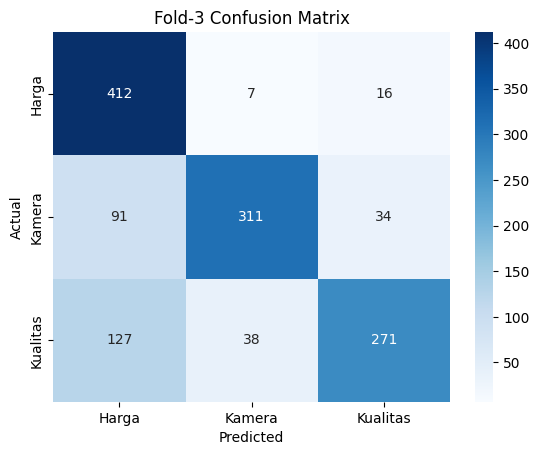


Confusion Matrix Fold-4 (k=26) | F1-macro: 77.36


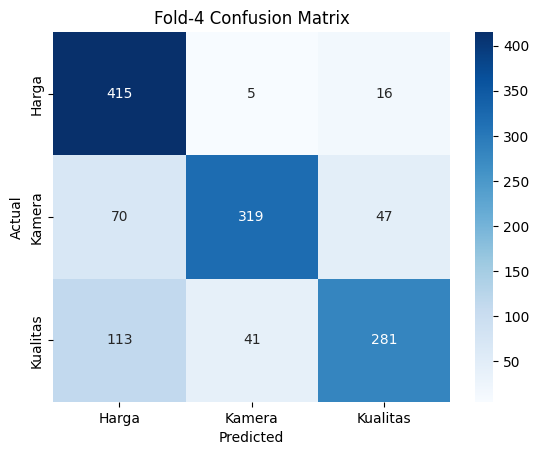


Confusion Matrix Fold-5 (k=26) | F1-macro: 80.67


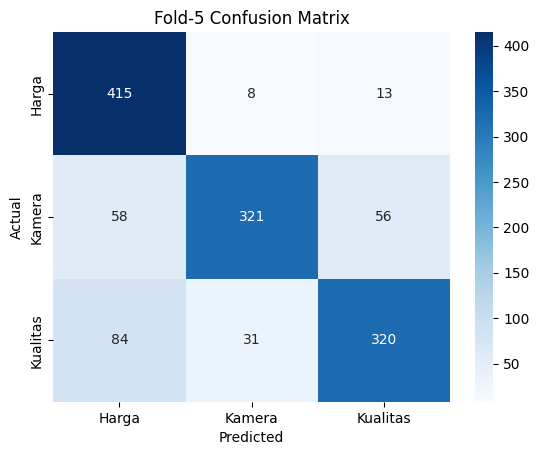


=== Evaluasi MKNN Aspek dengan k=30 ===

Confusion Matrix Fold-1 (k=30) | F1-macro: 81.45


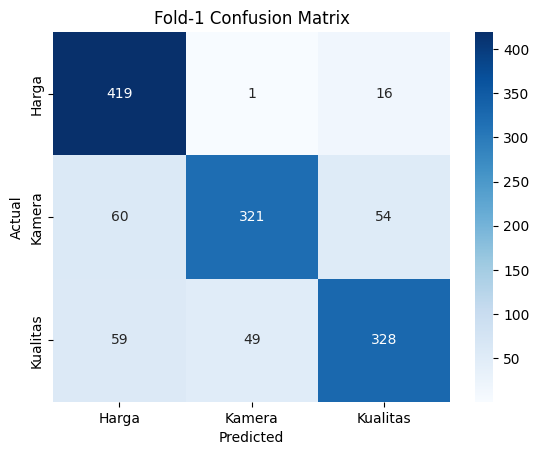


Confusion Matrix Fold-2 (k=30) | F1-macro: 78.40


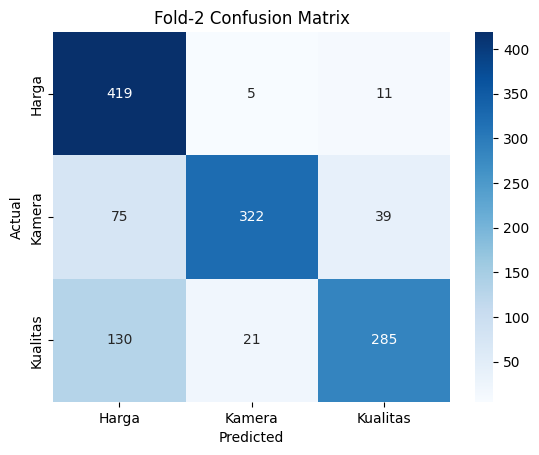


Confusion Matrix Fold-3 (k=30) | F1-macro: 76.60


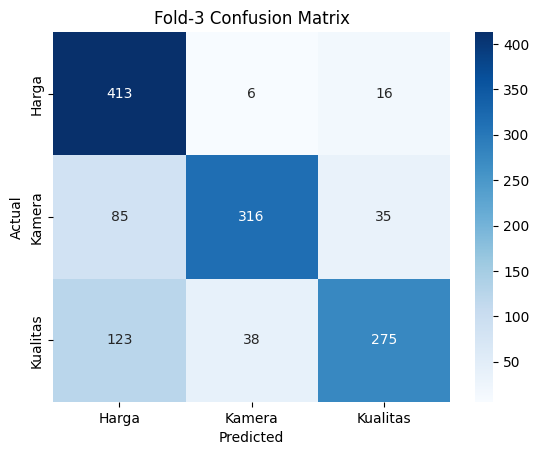


Confusion Matrix Fold-4 (k=30) | F1-macro: 77.66


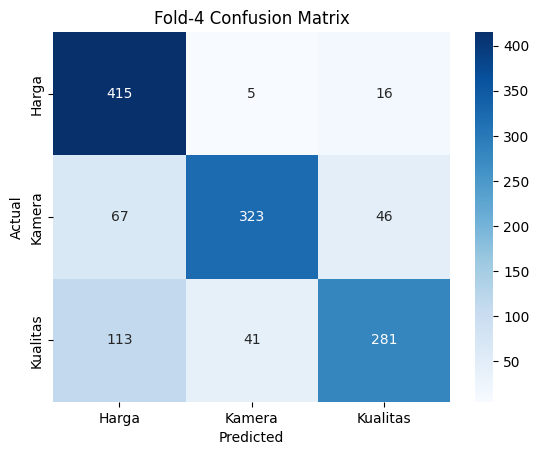


Confusion Matrix Fold-5 (k=30) | F1-macro: 80.83


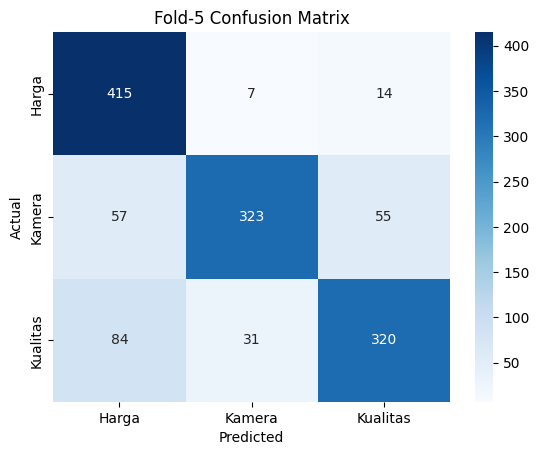


Hasil Cross-Validation MKNN Aspek (k=20):


,Fold-1,Fold-2,Fold-3,Fold-4,Fold-5,Rata-Rata
Harga,95.640000,96.78,95.170000,95.18,94.720000,95.50
Kamera,71.490000,71.10,71.100000,71.79,72.870000,71.67
Kualitas,70.180000,53.67,60.090000,64.60,69.660000,63.64
Rata-Rata,79.103333,73.85,75.453333,77.19,79.083333,NaN



Hasil Cross-Validation MKNN Aspek (k=26):


,Fold-1,Fold-2,Fold-3,Fold-4,Fold-5,Rata-Rata
Harga,96.10,96.32,94.710000,95.18,95.180000,95.50
Kamera,72.64,72.94,71.330000,73.17,73.790000,72.77
Kualitas,72.94,60.78,62.160000,64.60,73.560000,66.81
Rata-Rata,80.56,76.68,76.066667,77.65,80.843333,NaN



Hasil Cross-Validation MKNN Aspek (k=30):


,Fold-1,Fold-2,Fold-3,Fold-4,Fold-5,Rata-Rata
Harga,96.100000,96.320000,94.94,95.180000,95.180000,95.54
Kamera,73.790000,73.850000,72.48,74.080000,74.250000,73.69
Kualitas,75.230000,65.370000,63.07,64.600000,73.560000,68.37
Rata-Rata,81.706667,78.513333,76.83,77.953333,80.996667,NaN


In [20]:
# cosine v3

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.metrics.cluster')

# Konfigurasi
k_values = [20, 26, 30]
alpha = 1e-6
max_features = 6000
min_df = 2

# Load Data
df = pd.read_excel("data_latih_oversampled_n1.xlsx")
df = df.dropna(subset=['text_stemmed', 'aspek'])
df['text_clean'] = df['text_stemmed'].apply(clean_text)
df['aspek'] = df['aspek'].str.capitalize().str.strip()

X_text = df['text_clean'].reset_index(drop=True)
y_aspek = df['aspek'].reset_index(drop=True)
aspek_list = sorted(y_aspek.unique())

final_result = {}

for k_mknn in k_values:
    print(f"\n=== Evaluasi MKNN Aspek dengan k={k_mknn} ===")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    result_per_fold = defaultdict(list)

    for fold_no, (train_idx, test_idx) in enumerate(skf.split(X_text, y_aspek), 1):
        X_train = X_text.iloc[train_idx].reset_index(drop=True)
        y_train = y_aspek.iloc[train_idx].reset_index(drop=True)
        X_test = X_text.iloc[test_idx].reset_index(drop=True)
        y_test = y_aspek.iloc[test_idx].reset_index(drop=True)

        # TF-IDF
        vectorizer = TfidfVectorizer(
            ngram_range=(1, 3),
            sublinear_tf=True,
            smooth_idf=True,
            min_df=min_df,
            max_df=0.9,
            max_features=max_features,
            norm='l2'
        )
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)

        # Encode label
        le = LabelEncoder()
        y_train_encoded = le.fit_transform(y_train)

        # Feature selection
        if X_train_tfidf.shape[1] > 300:
            selector = SelectKBest(score_func=chi2, k= 300)
            X_train_sel = selector.fit_transform(X_train_tfidf, y_train_encoded)
            X_test_sel = selector.transform(X_test_tfidf)
        else:
            X_train_sel = X_train_tfidf
            X_test_sel = X_test_tfidf

        # Validitas dengan cosine similarity
        sim_train = cosine_similarity(X_train_sel)
        dist_train = 1 - sim_train
        validitas = []
        for i in range(len(y_train)):
            distances = dist_train[i]
            neighbor_idx = np.argsort(distances)[1:k_mknn+1]
            neighbor_labels = y_train.iloc[neighbor_idx]
            same = np.sum(neighbor_labels == y_train.iloc[i])
            valid = (same + 1) / (k_mknn + 1)
            validitas.append(valid)
        validitas_train = pd.Series(validitas)

        # Prediksi MKNN
        predictions = []
        for i in range(X_test_sel.shape[0]):
            test_vec = X_test_sel[i:i+1]
            sims = cosine_similarity(test_vec, X_train_sel)[0]
            dists = 1 - sims

            weight_dict = defaultdict(float)
            for j, dist in enumerate(dists):
                valid = validitas_train.iloc[j]
                label = y_train.iloc[j]
                weight = (valid + 1e-3) / (dist + alpha)
                weight_dict[label] += weight

            pred = max(weight_dict.items(), key=lambda x: x[1])[0]
            predictions.append(pred)

        # Evaluasi
        df_temp = pd.DataFrame({'true': y_test, 'pred': predictions})
        cm = confusion_matrix(y_test, predictions, labels=aspek_list)
        f1 = f1_score(y_test, predictions, average='macro') * 100

        print(f"\nConfusion Matrix Fold-{fold_no} (k={k_mknn}) | F1-macro: {f1:.2f}")
        cm_df = pd.DataFrame(cm, index=aspek_list, columns=aspek_list)
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Fold-{fold_no} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Akurasi per kelas
        for aspek in aspek_list:
            mask = df_temp['true'] == aspek
            if mask.sum() > 0:
                acc = (df_temp.loc[mask, 'true'] == df_temp.loc[mask, 'pred']).mean()
                result_per_fold[aspek].append(round(acc * 100, 2))
            else:
                result_per_fold[aspek].append(None)

    # Rekap hasil
    df_result = pd.DataFrame(result_per_fold).T
    df_result.columns = [f'Fold-{i+1}' for i in range(5)]
    df_result['Rata-Rata'] = df_result.mean(axis=1).round(2)
    mean_per_fold = df_result.iloc[:, :-1].mean().to_frame().T
    mean_per_fold.index = ['Rata-Rata']
    df_result = pd.concat([df_result, mean_per_fold])

    final_result[f'k={k_mknn}'] = df_result

# Tampilkan hasil akhir
for k_label, df_k in final_result.items():
    print(f"\nHasil Cross-Validation MKNN Aspek ({k_label}):")
    display(df_k)



=== Evaluasi MKNN Sentimen dengan k=20 ===

Confusion Matrix Fold-1 (k=20) | F1-macro: 86.78


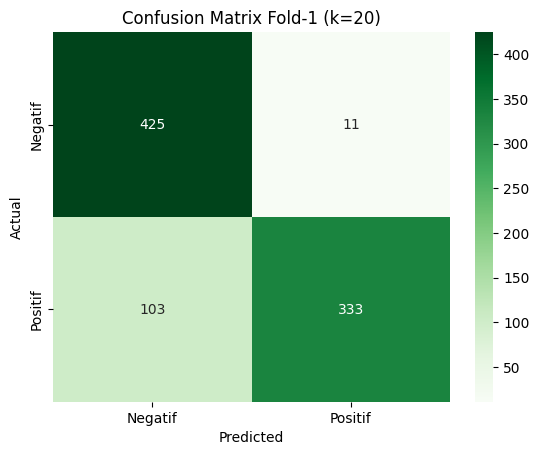


Confusion Matrix Fold-2 (k=20) | F1-macro: 86.53


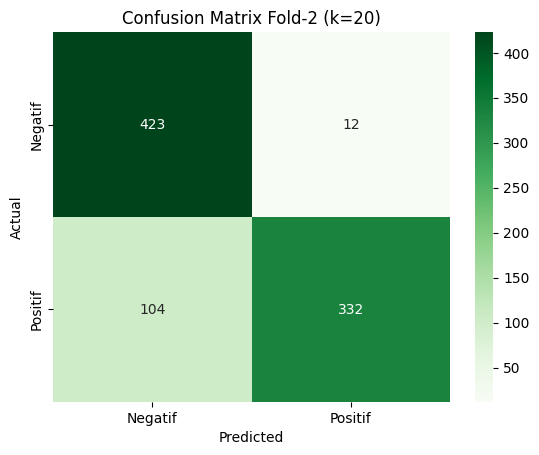


Confusion Matrix Fold-3 (k=20) | F1-macro: 85.42


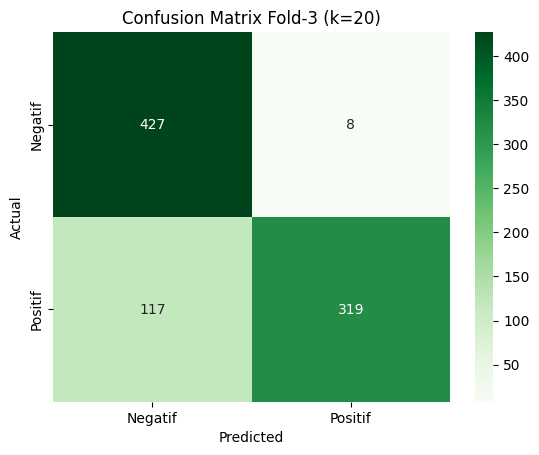


Confusion Matrix Fold-4 (k=20) | F1-macro: 85.93


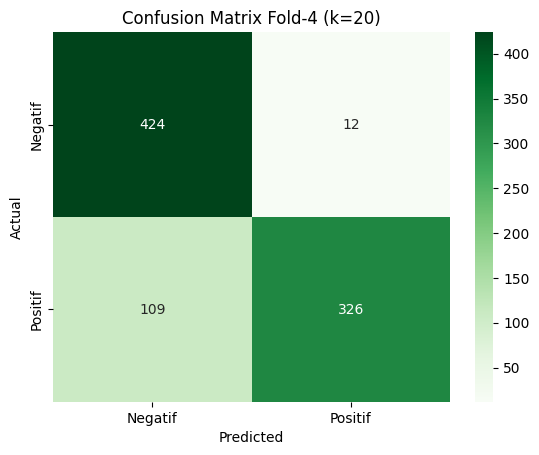


Confusion Matrix Fold-5 (k=20) | F1-macro: 86.62


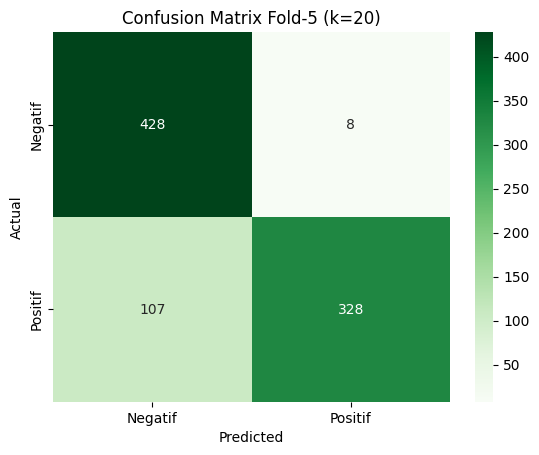


=== Evaluasi MKNN Sentimen dengan k=26 ===

Confusion Matrix Fold-1 (k=26) | F1-macro: 86.06


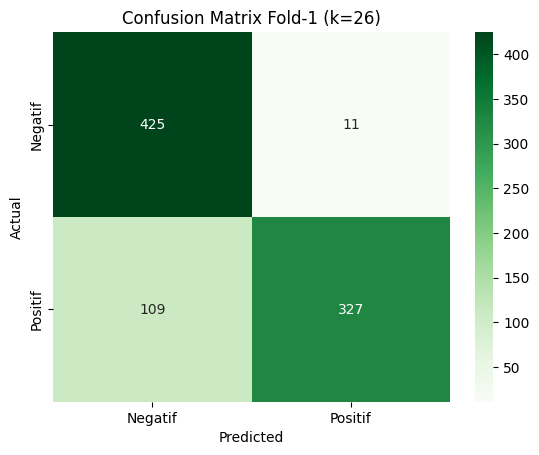


Confusion Matrix Fold-2 (k=26) | F1-macro: 86.06


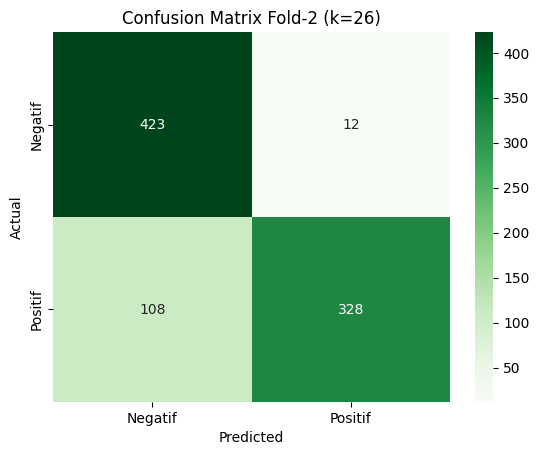


Confusion Matrix Fold-3 (k=26) | F1-macro: 85.17


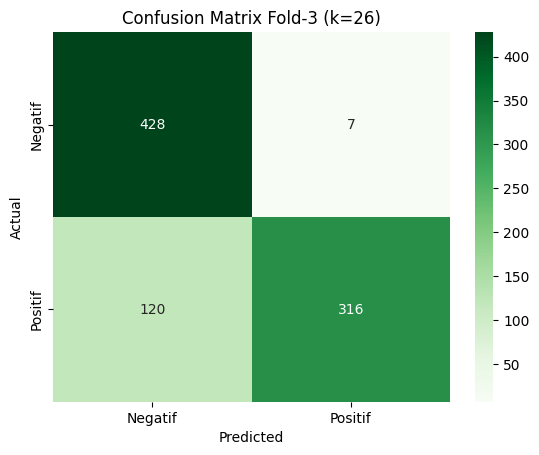


Confusion Matrix Fold-4 (k=26) | F1-macro: 85.57


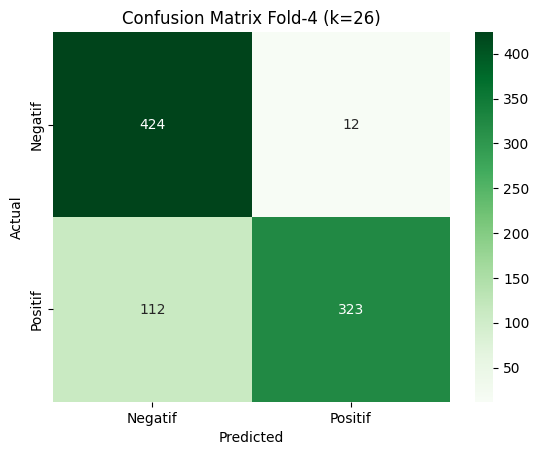


Confusion Matrix Fold-5 (k=26) | F1-macro: 86.16


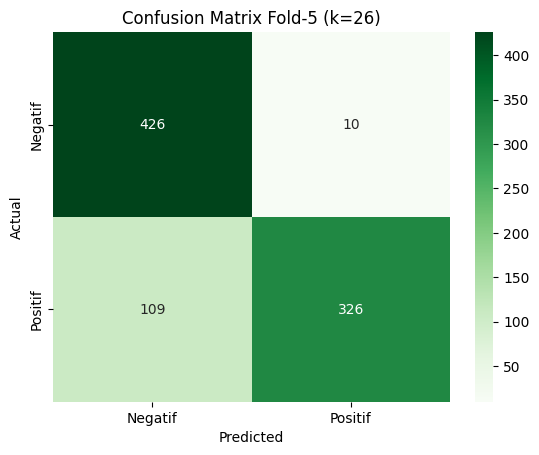


=== Evaluasi MKNN Sentimen dengan k=30 ===

Confusion Matrix Fold-1 (k=30) | F1-macro: 85.45


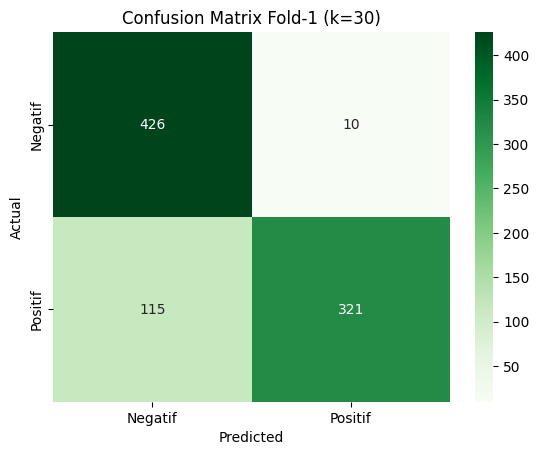


Confusion Matrix Fold-2 (k=30) | F1-macro: 85.70


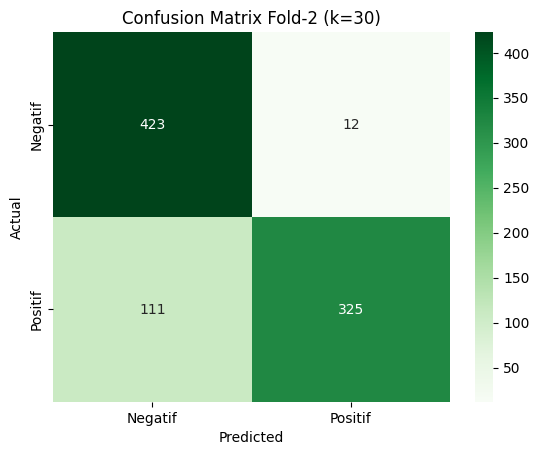


Confusion Matrix Fold-3 (k=30) | F1-macro: 85.30


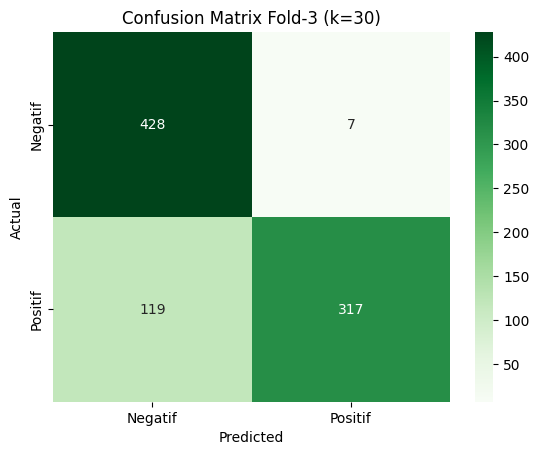


Confusion Matrix Fold-4 (k=30) | F1-macro: 85.93


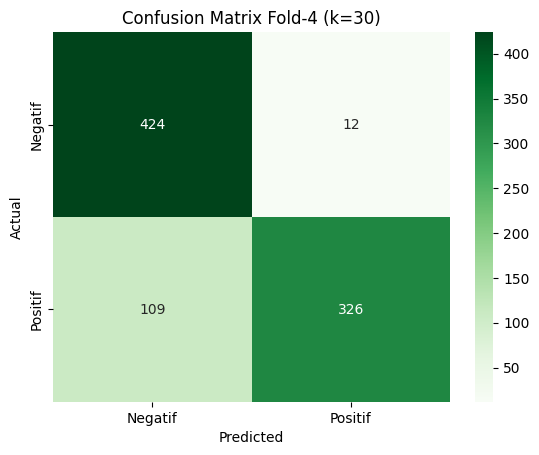


Confusion Matrix Fold-5 (k=30) | F1-macro: 86.38


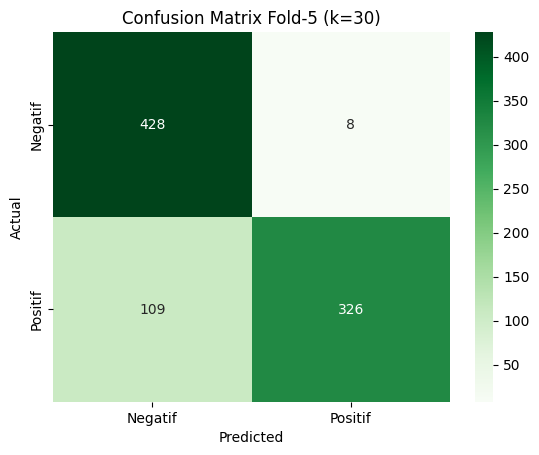


Hasil Cross-Validation MKNN Sentimen (k=20):


,Fold-1,Fold-2,Fold-3,Fold-4,Fold-5,Rata-Rata
Negatif,97.48,97.240,98.160,97.250,98.170,97.66
Positif,76.38,76.150,73.170,74.940,75.400,75.21
Rata-Rata,86.93,86.695,85.665,86.095,86.785,NaN



Hasil Cross-Validation MKNN Sentimen (k=26):


,Fold-1,Fold-2,Fold-3,Fold-4,Fold-5,Rata-Rata
Negatif,97.48,97.240,98.390,97.25,97.710,97.61
Positif,75.00,75.230,72.480,74.25,74.940,74.38
Rata-Rata,86.24,86.235,85.435,85.75,86.325,NaN



Hasil Cross-Validation MKNN Sentimen (k=30):


,Fold-1,Fold-2,Fold-3,Fold-4,Fold-5,Rata-Rata
Negatif,97.710,97.24,98.39,97.250,98.170,97.75
Positif,73.620,74.54,72.71,74.940,74.940,74.15
Rata-Rata,85.665,85.89,85.55,86.095,86.555,NaN


In [24]:
import pandas as pd
import numpy as np
import re
import string
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.metrics.cluster')

# === Konfigurasi ===
k_values = [20, 26, 30]
alpha = 1e-6
min_df = 2
max_df = 0.95
max_features = 5000




# === Load Data ===
df = pd.read_excel("data_latih_oversampled_n1.xlsx")
df = df.dropna(subset=['text_stemmed', 'sentimen'])
df['text_stemmed'] = df['text_stemmed'].apply(clean_text)
df['sentimen'] = df['sentimen'].str.capitalize().str.strip()
df = df[df['sentimen'].isin(['Positif', 'Negatif'])]

X_text = df['text_stemmed'].reset_index(drop=True)
y_sentimen = df['sentimen'].reset_index(drop=True)
sentimen_list = sorted(y_sentimen.unique())

final_result = {}

# === Loop k MKNN ===
for k_mknn in k_values:
    print(f"\n=== Evaluasi MKNN Sentimen dengan k={k_mknn} ===")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    result_per_fold = defaultdict(list)
    
    for fold_no, (train_idx, test_idx) in enumerate(skf.split(X_text, y_sentimen), 1):
        X_train = X_text.iloc[train_idx].reset_index(drop=True)
        y_train = y_sentimen.iloc[train_idx].reset_index(drop=True)
        X_test = X_text.iloc[test_idx].reset_index(drop=True)
        y_test = y_sentimen.iloc[test_idx].reset_index(drop=True)

        # === TF-IDF ===
        vectorizer = TfidfVectorizer(
            ngram_range=(1, 3),
            sublinear_tf=True,
            smooth_idf=True,
            min_df=min_df,
            max_df=max_df,
            max_features=max_features,
            norm='l2'
        )
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)

        # === Seleksi Fitur Adaptif ===
        if X_train_tfidf.shape[1] > 300:
            selector = SelectKBest(score_func=chi2, k=300)
            X_train_sel = selector.fit_transform(X_train_tfidf, y_train)
            X_test_sel = selector.transform(X_test_tfidf)
        else:
            X_train_sel = X_train_tfidf
            X_test_sel = X_test_tfidf

        # === Hitung Validitas (Cosine) ===
        sim_train = cosine_similarity(X_train_sel)
        dist_train = 1 - sim_train

        validitas = []
        for i in range(len(y_train)):
            distances = dist_train[i].copy()
            distances[i] = np.inf
            neighbor_idx = np.argsort(distances)[:k_mknn]
            neighbor_labels = y_train.iloc[neighbor_idx]
            same = np.sum(neighbor_labels == y_train.iloc[i])
            valid = (same + 1) / (k_mknn + 1)
            validitas.append(valid)
        validitas_train = pd.Series(validitas)

        # === Prediksi MKNN ===
        predictions = []
        for i in range(X_test_sel.shape[0]):
            test_vec = X_test_sel[i:i+1]
            sims = cosine_similarity(test_vec, X_train_sel)[0]
            dists = 1 - sims

            weight_dict = defaultdict(float)
            for j, dist in enumerate(dists):
                valid = validitas_train.iloc[j]
                label = y_train.iloc[j]
                weight = (valid + 1e-3) / (dist + alpha)
                weight_dict[label] += weight

            pred = max(weight_dict.items(), key=lambda x: x[1])[0]
            predictions.append(pred)

        # === Evaluasi ===
        df_temp = pd.DataFrame({'true': y_test, 'pred': predictions})
        cm = confusion_matrix(y_test, predictions, labels=sentimen_list)
        f1 = f1_score(y_test, predictions, average='macro') * 100

        print(f"\nConfusion Matrix Fold-{fold_no} (k={k_mknn}) | F1-macro: {f1:.2f}")
        cm_df = pd.DataFrame(cm, index=sentimen_list, columns=sentimen_list)
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Greens')
        plt.title(f'Confusion Matrix Fold-{fold_no} (k={k_mknn})')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Akurasi per kelas
        for sentimen in sentimen_list:
            mask = df_temp['true'] == sentimen
            if mask.sum() > 0:
                acc = (df_temp.loc[mask, 'true'] == df_temp.loc[mask, 'pred']).mean()
                result_per_fold[sentimen].append(round(acc * 100, 2))
            else:
                result_per_fold[sentimen].append(None)

     # === Rekap ===
    df_result = pd.DataFrame(result_per_fold).T
    df_result.columns = [f'Fold-{i+1}' for i in range(5)]
    df_result['Rata-Rata'] = df_result.mean(axis=1).round(2)
    mean_per_fold = df_result.iloc[:, :-1].mean().to_frame().T
    mean_per_fold.index = ['Rata-Rata']
    df_result = pd.concat([df_result, mean_per_fold])

    final_result[f'k={k_mknn}'] = df_result

# === Tampilkan Semua Hasil ===
for k_label, df_k in final_result.items():
    print(f"\nHasil Cross-Validation MKNN Sentimen ({k_label}):")
    display(df_k)





=== Aspek: KUALITAS ===
Cross-Validation F1-macro: 0.6683 ± 0.0868

Test Classification Report:
              precision    recall  f1-score   support

     Negatif     0.6589    0.9658    0.7833       146
     Positif     0.9351    0.4966    0.6486       145

    accuracy                         0.7320       291
   macro avg     0.7970    0.7312    0.7160       291
weighted avg     0.7965    0.7320    0.7162       291



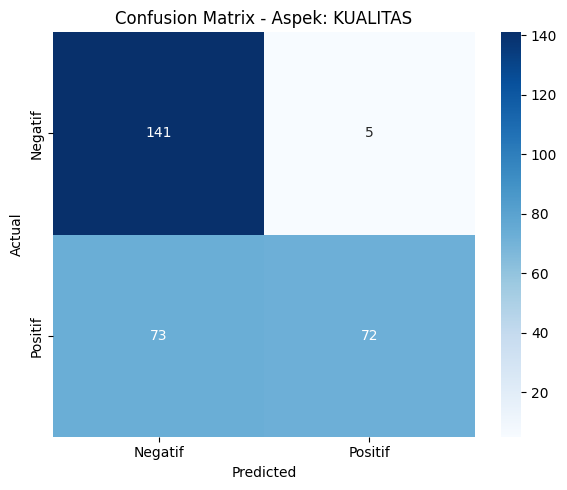

Model disimpan: mknn_model_kualitas.pkl
Data latih disimpan: mknn_data_latih_kualitas.pkl

=== Aspek: HARGA ===
Cross-Validation F1-macro: 0.9690 ± 0.0109

Test Classification Report:
              precision    recall  f1-score   support

     Negatif     1.0000    0.9315    0.9645       146
     Positif     0.9355    1.0000    0.9667       145

    accuracy                         0.9656       291
   macro avg     0.9677    0.9658    0.9656       291
weighted avg     0.9679    0.9656    0.9656       291



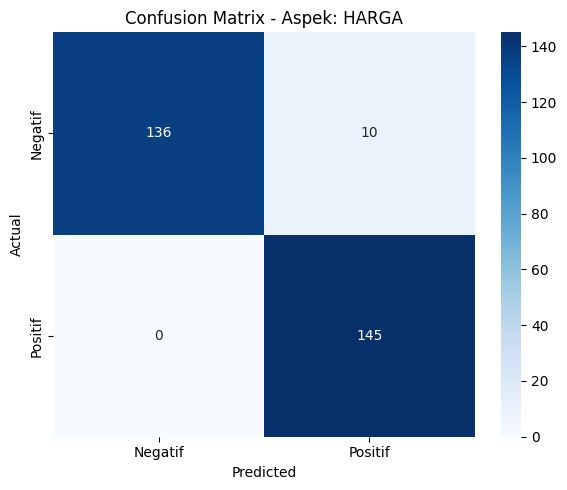

Model disimpan: mknn_model_harga.pkl
Data latih disimpan: mknn_data_latih_harga.pkl

=== Aspek: KAMERA ===
Cross-Validation F1-macro: 0.8723 ± 0.0115

Test Classification Report:
              precision    recall  f1-score   support

     Negatif     0.9259    0.8562    0.8897       146
     Positif     0.8654    0.9310    0.8970       145

    accuracy                         0.8935       291
   macro avg     0.8957    0.8936    0.8933       291
weighted avg     0.8958    0.8935    0.8933       291



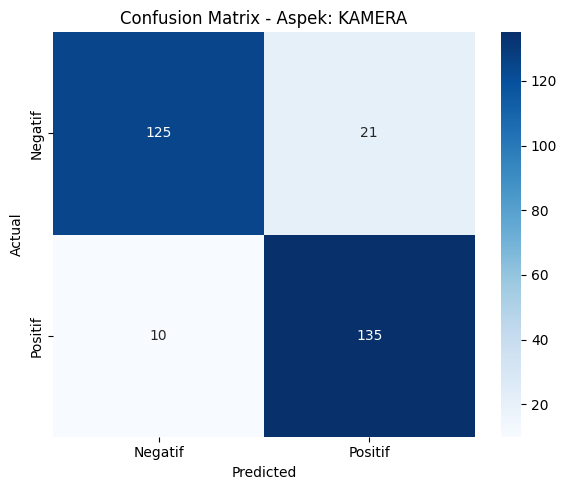

Model disimpan: mknn_model_kamera.pkl
Data latih disimpan: mknn_data_latih_kamera.pkl


In [26]:
#train

from sklearn.pipeline import Pipeline
import joblib
import warnings

warnings.filterwarnings("ignore")

# === Load & Preprocessing ===
df = pd.read_excel("data_latih_oversampled_n1.xlsx")
df = df.dropna(subset=['text_stemmed', 'aspek', 'sentimen'])
df['aspek'] = df['aspek'].str.lower().str.strip()
df['sentimen'] = df['sentimen'].str.capitalize().str.strip()
df = df[df['sentimen'].isin(['Positif', 'Negatif'])]
df['sentimen'] = df['sentimen'].map({'Positif': 1, 'Negatif': -1})

# Konfigurasi
k_mknn = 30
alpha = 1e-6
epsilon = 1e-3
aspek_list = df['aspek'].unique()

# === Looping per Aspek ===
for aspek in aspek_list:
    print(f"\n=== Aspek: {aspek.upper()} ===")

    df_aspek = df[df['aspek'] == aspek]
    X = df_aspek['text_stemmed'].reset_index(drop=True)
    y = df_aspek['sentimen'].reset_index(drop=True)

    # Cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    for train_idx, val_idx in skf.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
        tf_train = vectorizer.fit_transform(X_train)
        tf_val = vectorizer.transform(X_val)

        selector = SelectKBest(score_func=chi2, k=min(300, tf_train.shape[1]))
        X_train_sel = selector.fit_transform(tf_train, y_train)
        X_val_sel = selector.transform(tf_val)

        sim_train = cosine_similarity(X_train_sel)
        dist_train = 1 - sim_train
        validitas = []
        for i in range(len(y_train)):
            distances = dist_train[i].copy()
            distances[i] = np.inf
            neighbors = np.argsort(distances)[:k_mknn]
            neighbor_labels = y_train.iloc[neighbors]
            match = np.sum(neighbor_labels == y_train.iloc[i])
            validitas.append((match + 1) / (k_mknn + 1))
        validitas_train = pd.Series(validitas)

        preds = []
        for i in range(X_val_sel.shape[0]):
            sims = cosine_similarity(X_val_sel[i:i+1], X_train_sel)[0]
            dists = 1 - sims
            weights = defaultdict(float)
            for j, d in enumerate(dists):
                label = y_train.iloc[j]
                weight = (validitas_train[j] + epsilon) / (d + alpha)
                weights[label] += weight
            pred = max(weights.items(), key=lambda x: x[1])[0]
            preds.append(pred)

        f1 = f1_score(y_val, preds, average='macro')
        f1_scores.append(f1)

    print(f"Cross-Validation F1-macro: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

    # Train final model dan evaluasi ke test
    X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
    tf_train = vectorizer.fit_transform(X_train_all)
    tf_test = vectorizer.transform(X_test)

    selector = SelectKBest(score_func=chi2, k=min(300, tf_train.shape[1]))
    X_train_sel = selector.fit_transform(tf_train, y_train_all)
    X_test_sel = selector.transform(tf_test)

    sim_train = cosine_similarity(X_train_sel)
    dist_train = 1 - sim_train
    validitas = []
    for i in range(len(y_train_all)):
        distances = dist_train[i].copy()
        distances[i] = np.inf
        neighbors = np.argsort(distances)[:k_mknn]
        neighbor_labels = y_train_all.iloc[neighbors]
        match = np.sum(neighbor_labels == y_train_all.iloc[i])
        validitas.append((match + 1) / (k_mknn + 1))
    validitas_train = pd.Series(validitas)

    preds_test = []
    for i in range(X_test_sel.shape[0]):
        sims = cosine_similarity(X_test_sel[i:i+1], X_train_sel)[0]
        dists = 1 - sims
        weights = defaultdict(float)
        for j, d in enumerate(dists):
            label = y_train_all.iloc[j]
            weight = (validitas_train[j] + epsilon) / (d + alpha)
            weights[label] += weight
        pred = max(weights.items(), key=lambda x: x[1])[0]
        preds_test.append(pred)

    print("\nTest Classification Report:")
    print(classification_report(y_test, preds_test, target_names=["Negatif", "Positif"], digits=4))

    cm = confusion_matrix(y_test, preds_test, labels=[-1, 1])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negatif", "Positif"], yticklabels=["Negatif", "Positif"])
    plt.title(f'Confusion Matrix - Aspek: {aspek.upper()}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Simpan pipeline dan data latih validitas
    pipeline = Pipeline([
        ('tfidf', vectorizer),
        ('select', selector)
    ])
    pipeline.fit(X_train_all, y_train_all)
    joblib.dump(pipeline, f"mknn_model_{aspek}.pkl")
    joblib.dump((X_train_sel, y_train_all, validitas_train), f"mknn_data_latih_{aspek}.pkl")
    print(f"Model disimpan: mknn_model_{aspek}.pkl")
    print(f"Data latih disimpan: mknn_data_latih_{aspek}.pkl")




=== Aspek: KAMERA ===
Classification Report:
              precision    recall  f1-score   support

     Negatif     0.8390    0.8390    0.8390       118
     Positif     0.7765    0.7765    0.7765        85

    accuracy                         0.8128       203
   macro avg     0.8077    0.8077    0.8077       203
weighted avg     0.8128    0.8128    0.8128       203



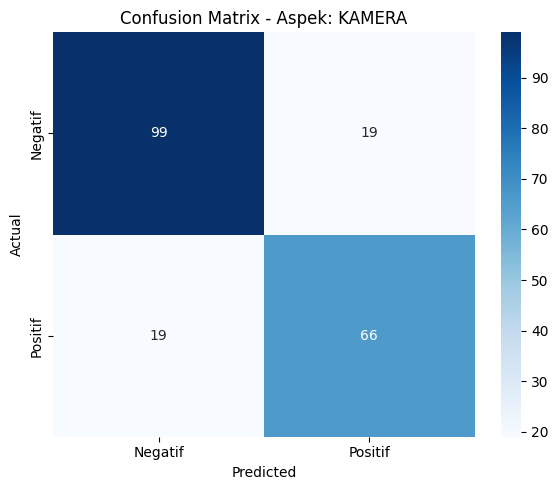


=== Aspek: KUALITAS ===
Classification Report:
              precision    recall  f1-score   support

     Negatif     0.6464    0.9679    0.7752       187
     Positif     0.9259    0.4310    0.5882       174

    accuracy                         0.7091       361
   macro avg     0.7862    0.6995    0.6817       361
weighted avg     0.7811    0.7091    0.6851       361



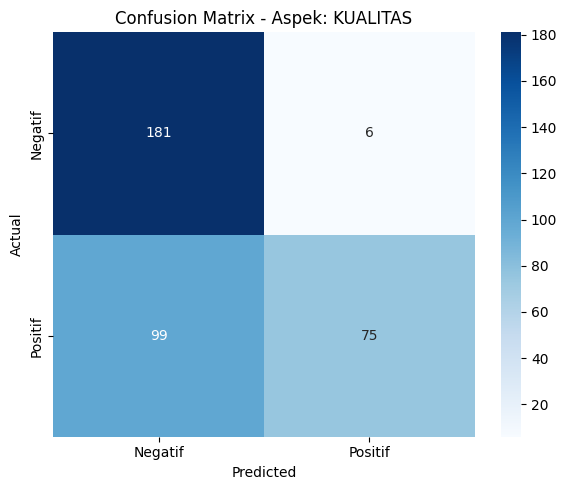


=== Aspek: HARGA ===
Classification Report:
              precision    recall  f1-score   support

     Negatif     0.9091    0.3226    0.4762        31
     Positif     0.5333    0.9600    0.6857        25

    accuracy                         0.6071        56
   macro avg     0.7212    0.6413    0.5810        56
weighted avg     0.7413    0.6071    0.5697        56



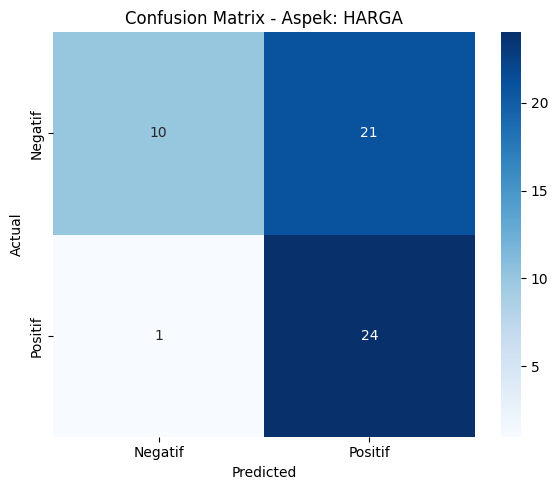

In [30]:
#test new

# === Load Data Uji ===
df_uji = pd.read_excel("data_uji_n1.xlsx")
df_uji = df_uji.dropna(subset=['text_stemmed', 'aspek', 'sentimen_baru'])
df_uji['aspek'] = df_uji['aspek'].str.lower().str.strip()
df_uji['sentimen_baru'] = df_uji['sentimen_baru'].str.capitalize().str.strip()
df_uji = df_uji[df_uji['sentimen_baru'].isin(['Positif', 'Negatif'])]
df_uji['sentimen_baru'] = df_uji['sentimen_baru'].map({'Positif': 1, 'Negatif': -1})

# Parameter
k_mknn = 30
alpha = 1e-6
epsilon = 1e-3

aspek_list = df_uji['aspek'].unique()

for aspek in aspek_list:
    print(f"\n=== Aspek: {aspek.upper()} ===")
    df_aspek_uji = df_uji[df_uji['aspek'] == aspek]

    if df_aspek_uji.empty:
        print("Data uji kosong untuk aspek ini.")
        continue

    X_test = df_aspek_uji['text_stemmed'].reset_index(drop=True)
    y_test = df_aspek_uji['sentimen_baru'].reset_index(drop=True)

    try:
        # Load pipeline dan data latih
        pipeline = joblib.load(f"mknn_model_{aspek}.pkl")
        X_train_sel, y_train, validitas_train = joblib.load(f"mknn_data_latih_{aspek}.pkl")

        X_test_sel = pipeline.transform(X_test)

        preds = []
        for i in range(X_test_sel.shape[0]):
            sims = cosine_similarity(X_test_sel[i:i+1], X_train_sel)[0]
            dists = 1 - sims
            weights = defaultdict(float)
            for j, d in enumerate(dists):
                label = y_train.iloc[j]
                weight = (validitas_train[j] + epsilon) / (d + alpha)
                weights[label] += weight
            pred = max(weights.items(), key=lambda x: x[1])[0]
            preds.append(pred)

        print("Classification Report:")
        print(classification_report(y_test, preds, target_names=["Negatif", "Positif"], digits=4))

        cm = confusion_matrix(y_test, preds, labels=[-1, 1])
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=["Negatif", "Positif"], yticklabels=["Negatif", "Positif"])
        plt.title(f'Confusion Matrix - Aspek: {aspek.upper()}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print(f"Model atau data latih untuk aspek '{aspek}' tidak ditemukan.")
